# Two implementations of RBF layer in Neural Network - Nikolaos Andriotis

In the first implementation, the RBF layer is given the centroids from scikit's KMeans method and the standard deviation for the centroids is calculated from the formula below:

$$b = \frac{\sqrt{2 * K}}{Dmax}$$

* K : the number of centroids

* Dmax : the maximum distance between any 2 centroids

In the second implementation, the RBF layer is  given the centroids randomly. The standard deviation is given by the same formula.

In [716]:
# standard imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

## First, I need to download the whole dataset.

In [687]:
# Download the train data (images and labels)
train_data = datasets.MNIST(root='./Data/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())

train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./Data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [688]:
# Download the test data (images and labels)
test_data = datasets.MNIST(root='./Data/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./Data/
    Split: Test
    StandardTransform
Transform: ToTensor()

## Then I implement the required classes.

In [731]:
# RBF Layer with centers and deviation taken from the kmeans algorithm
class RBF(nn.Module):

    def __init__(self, in_features, out_features, centers, s):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.centers = centers
        self.s = s

    def forward(self, input):
        # the input and the centers must have the same size
        common_size = (input.size(0), self.out_features, self.in_features)
        # we don't know the number of centroids
        x = input.unsqueeze(1).expand(common_size)
        # we don't know the batch_size
        c = self.centers.unsqueeze(0).expand(common_size)
        distances = (x - c).pow(2).sum(-1).pow(0.5)
        return self.gaussian(distances)

    # simple gaussian implementation
    def gaussian(self, alpha):
        return torch.exp(-1*(alpha / self.s).pow(2))

# Defining a Network with an RBF layer followed by a linear layer
class Network(nn.Module):

    def __init__(self, layer, centers, s):
        super().__init__()
        self.rbf = RBF(layer[0], layer[1], centers, s)
        self.linear = nn.Linear(layer[1], layer[2])
    
    def forward(self,X):
        X = self.rbf.forward(X)
        X = self.linear(X)
        return F.log_softmax(X, dim=1)

## I split the training data to images and labels because I want to use the images for the KMeans method.

In [723]:
# split the train images from the labels
X_train = train_data.data.view(-1, 784) / 255
y_train = train_data.targets.view(-1,1)

# split the test images from the labels
X_test = test_data.data.view(-1, 784) / 255
y_test = test_data.targets.view(-1,1)

In [724]:
# hyper-parameter
n_clusters = 300

# Get the centers from the KMean method
kmeans = KMeans(n_clusters=n_clusters).fit(X_train)
mean_centers = torch.Tensor(kmeans.cluster_centers_)

# Knowing the centers, calculate beta
mean_dmax = torch.nn.functional.pdist(input=mean_centers, p=2).max()
mean_s = math.sqrt(2 * n_clusters) / mean_dmax

# Randomly pick the centers
random_centers = X_train[np.random.choice(range(len(X_train)), n_clusters, replace=False)]

# Knowing the centers, calculate beta
random_dmax = torch.nn.functional.pdist(input=random_centers, p=2).max()
random_s = math.sqrt(2 * n_clusters) / random_dmax

In [729]:
mean_model = Network([784, n_clusters, 10], mean_centers, mean_s)
random_model = Network([784, n_clusters, 10], random_centers, random_s)

In [730]:
def train(model, epochs, batch_size, lr, per):

    torch.manual_seed(42)

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True)

    test_loader = DataLoader(test_data,
                             batch_size=batch_size,
                             shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # For every epoch i will losses and accuracies
    ###############
    trn_losses = []
    trn_acc = []

    tst_losses = []
    tst_acc = []
    ###############

    for i in range(epochs):
        # in the currect epoch, how many did it get correct?
        trn_corr_per_epoch = 0
        tst_corr_per_epoch = 0
    
        # run the training batches
        for b, (X_train, y_train) in enumerate(train_loader):
            # track batch number
            b += 1
            # apply the model
            y_pred = model(X_train.view(batch_size, -1))
            loss = criterion(y_pred, y_train)
    
            # in the current batch, how many did it get correct?
            predicted = torch.max(y_pred.data, 1)[1]
            trn_corr_per_epoch += (predicted == y_train).sum()
            
            if b%int(60000/(per*batch_size)) == 0:
                print(f"PART TRAINING -> epoch : {i:2} || batch : {b:4} [{batch_size*b}/60000] || loss: {loss.item():10.8f} || accuracy: {100*(trn_corr_per_epoch/(batch_size*b)):1.5f}%")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        trn_losses.append(loss)
        trn_acc.append(100*(trn_corr_per_epoch/60000))
        print(f'TOTAL TRAINING -> epoch : {i:2} || loss: {loss.item():10.8f} || accuracy: {100*trn_corr_per_epoch/60000:1.5f}%')
    
        with torch.no_grad():

            for b, (X_test, y_test) in enumerate(test_loader):

                # apply the model
                y_val = model(X_test.view(batch_size, -1))
                loss = criterion(y_val, y_train)

                predicted = torch.max(y_val.data, 1)[1]
                tst_corr_per_epoch += (predicted == y_test).sum()

        tst_losses.append(loss)
        tst_acc.append(100*(tst_corr_per_epoch/10000))
        print(f'TOTAL TESTING -> epoch : {i:2} || loss: {loss.item():10.8f} || accuracy : {100*(tst_corr_per_epoch/10000):1.5}%')

    return trn_losses, trn_acc, tst_losses, tst_acc

## I will first train with the random centers. I don't expect great results since I don't have many centers and the are also picked randomly.

In [698]:
# 100 n_clusters | 10 epochs | 100 batch_size | lr 0.1
trn_losses, trn_acc, tst_losses, tst_acc = train(random_model, 10, 100, 0.1, 5)

PART TRAINING -> epoch :  0 || batch :  120 [12000/60000] || loss: 2.29368520 || accuracy: 11.37500%
PART TRAINING -> epoch :  0 || batch :  240 [24000/60000] || loss: 2.29371095 || accuracy: 11.53750%
PART TRAINING -> epoch :  0 || batch :  360 [36000/60000] || loss: 2.29264927 || accuracy: 11.49722%
PART TRAINING -> epoch :  0 || batch :  480 [48000/60000] || loss: 2.29685163 || accuracy: 11.62708%
PART TRAINING -> epoch :  0 || batch :  600 [60000/60000] || loss: 2.34394240 || accuracy: 11.59167%
TOTAL TRAINING -> epoch :  0 || loss: 2.34394240 || accuracy: 11.59167%
TOTAL TESTING -> epoch :  0 || loss: 2.46189857 || accuracy : 12.46%
PART TRAINING -> epoch :  1 || batch :  120 [12000/60000] || loss: 2.28666925 || accuracy: 11.80000%
PART TRAINING -> epoch :  1 || batch :  240 [24000/60000] || loss: 2.31294990 || accuracy: 11.66250%
PART TRAINING -> epoch :  1 || batch :  360 [36000/60000] || loss: 2.29946303 || accuracy: 11.76944%
PART TRAINING -> epoch :  1 || batch :  480 [48000/

Text(0.5, 1.0, '100 n_clusters | 10 epochs | 100 batch_size | lr 0.1')

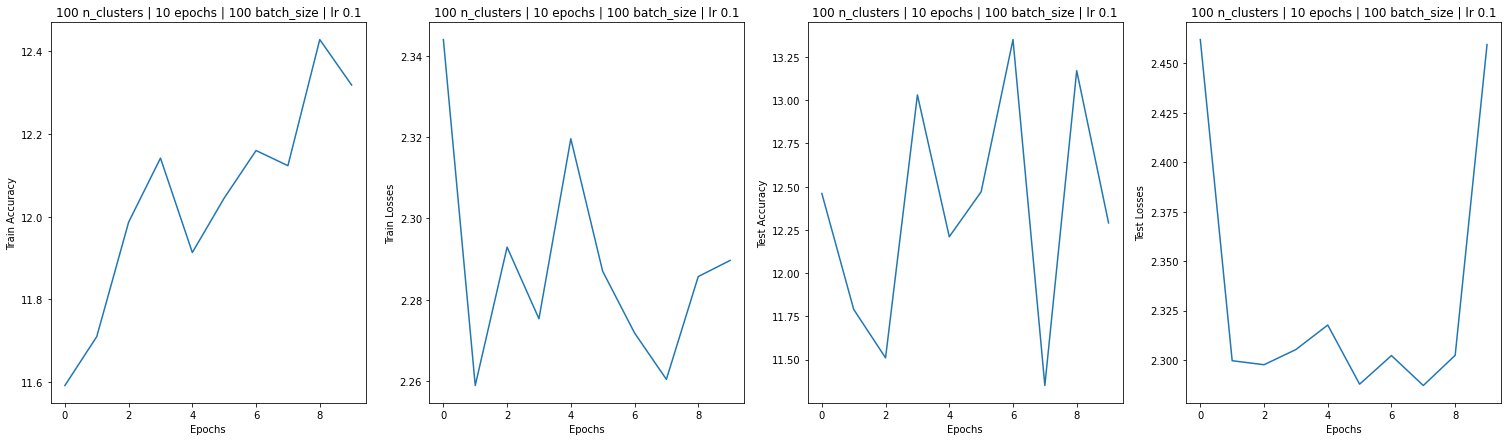

In [715]:
param = "100 n_clusters | 10 epochs | 100 batch_size | lr 0.1"
plt.figure(figsize=(26,7))
plt.subplot(141)
plt.plot(np.array(trn_acc))
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title(param)
plt.subplot(142)
plt.plot(np.array(trn_losses))
plt.xlabel('Epochs')
plt.ylabel('Train Losses')
plt.title(param)
plt.subplot(143)
plt.plot(np.array(tst_acc))
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title(param)
plt.subplot(144)
plt.plot(np.array(tst_losses))
plt.xlabel('Epochs')
plt.ylabel('Test Losses')
plt.title(param)

In [717]:
# 100 n_clusters | 10 epochs | 50 batch_size | lr 0.1
trn_losses, trn_acc, tst_losses, tst_acc = train(random_model, 10, 50, 0.1, 5)

PART TRAINING -> epoch :  0 || batch :  240 [12000/60000] || loss: 2.30359125 || accuracy: 12.13333%
PART TRAINING -> epoch :  0 || batch :  480 [24000/60000] || loss: 2.25852561 || accuracy: 12.17500%
PART TRAINING -> epoch :  0 || batch :  720 [36000/60000] || loss: 2.28570819 || accuracy: 12.17778%
PART TRAINING -> epoch :  0 || batch :  960 [48000/60000] || loss: 2.25241184 || accuracy: 12.35417%
PART TRAINING -> epoch :  0 || batch : 1200 [60000/60000] || loss: 2.34662843 || accuracy: 12.26500%
TOTAL TRAINING -> epoch :  0 || loss: 2.34662843 || accuracy: 12.26500%
TOTAL TESTING -> epoch :  0 || loss: 2.33314538 || accuracy : 11.35%
PART TRAINING -> epoch :  1 || batch :  240 [12000/60000] || loss: 2.26838446 || accuracy: 12.53333%
PART TRAINING -> epoch :  1 || batch :  480 [24000/60000] || loss: 2.34223080 || accuracy: 12.59167%
PART TRAINING -> epoch :  1 || batch :  720 [36000/60000] || loss: 2.28512073 || accuracy: 12.52222%
PART TRAINING -> epoch :  1 || batch :  960 [48000/

Text(0.5, 1.0, '100 n_clusters | 10 epochs | 50 batch_size | lr 0.1')

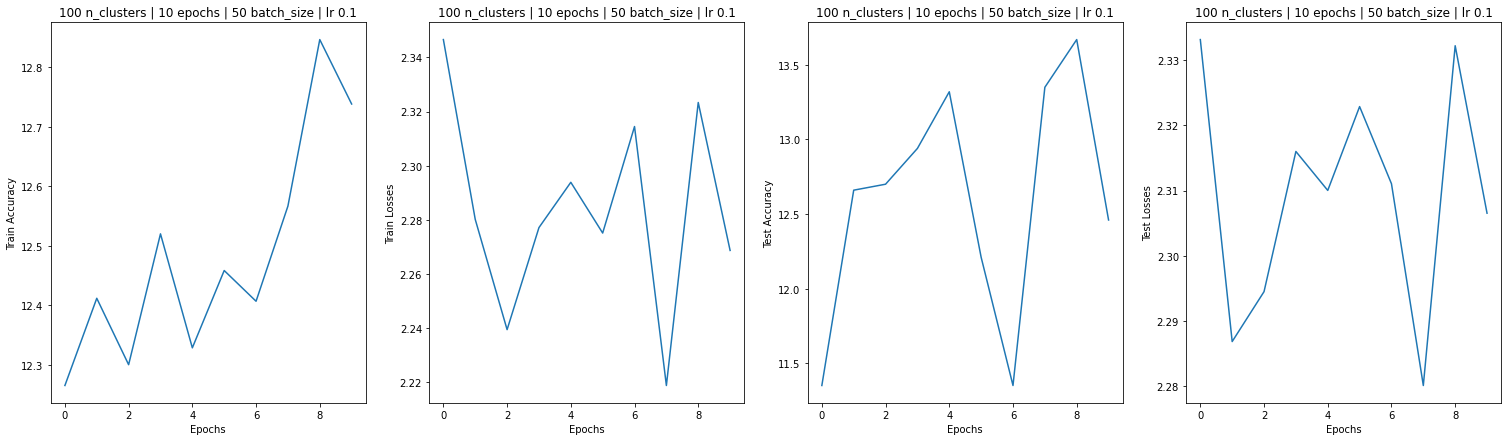

In [718]:
param = "100 n_clusters | 10 epochs | 50 batch_size | lr 0.1"
plt.figure(figsize=(26,7))
plt.subplot(141)
plt.plot(np.array(trn_acc))
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title(param)
plt.subplot(142)
plt.plot(np.array(trn_losses))
plt.xlabel('Epochs')
plt.ylabel('Train Losses')
plt.title(param)
plt.subplot(143)
plt.plot(np.array(tst_acc))
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title(param)
plt.subplot(144)
plt.plot(np.array(tst_losses))
plt.xlabel('Epochs')
plt.ylabel('Test Losses')
plt.title(param)

## I will know train the network with the Kmeans algorithm. I expect better but still not great results.

In [721]:
trn_losses, trn_acc, tst_losses, tst_acc = train(mean_model, 10, 100, 0.1, 5)

PART TRAINING -> epoch :  0 || batch :  120 [12000/60000] || loss: 2.28092027 || accuracy: 12.59167%
PART TRAINING -> epoch :  0 || batch :  240 [24000/60000] || loss: 2.29055929 || accuracy: 13.59583%
PART TRAINING -> epoch :  0 || batch :  360 [36000/60000] || loss: 2.27446938 || accuracy: 13.92778%
PART TRAINING -> epoch :  0 || batch :  480 [48000/60000] || loss: 2.24979544 || accuracy: 14.36042%
PART TRAINING -> epoch :  0 || batch :  600 [60000/60000] || loss: 2.32403612 || accuracy: 14.71167%
TOTAL TRAINING -> epoch :  0 || loss: 2.32403612 || accuracy: 14.71167%
TOTAL TESTING -> epoch :  0 || loss: 2.36050677 || accuracy : 17.37%
PART TRAINING -> epoch :  1 || batch :  120 [12000/60000] || loss: 2.23864055 || accuracy: 16.57500%
PART TRAINING -> epoch :  1 || batch :  240 [24000/60000] || loss: 2.23570657 || accuracy: 16.34167%
PART TRAINING -> epoch :  1 || batch :  360 [36000/60000] || loss: 2.19866872 || accuracy: 16.38889%
PART TRAINING -> epoch :  1 || batch :  480 [48000/

Text(0.5, 1.0, '100 n_clusters | 10 epochs | 100 batch_size | lr 0.1')

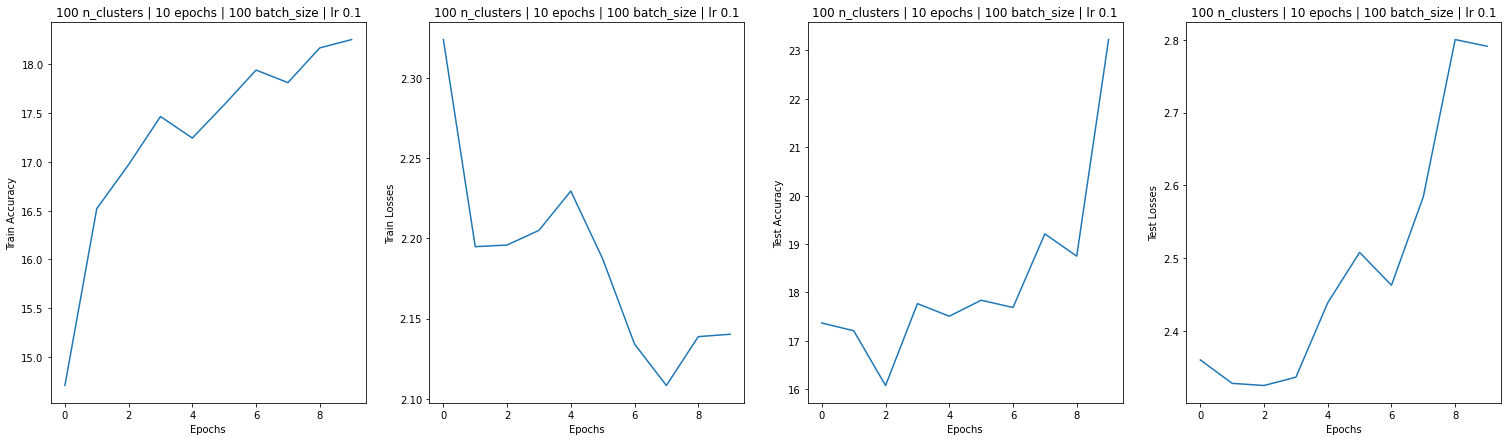

In [722]:
param = "100 n_clusters | 10 epochs | 100 batch_size | lr 0.1"
plt.figure(figsize=(26,7))
plt.subplot(141)
plt.plot(np.array(trn_acc))
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title(param)
plt.subplot(142)
plt.plot(np.array(trn_losses))
plt.xlabel('Epochs')
plt.ylabel('Train Losses')
plt.title(param)
plt.subplot(143)
plt.plot(np.array(tst_acc))
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title(param)
plt.subplot(144)
plt.plot(np.array(tst_losses))
plt.xlabel('Epochs')
plt.ylabel('Test Losses')
plt.title(param)

## Now I use 300 centers and I expect far better results both from the random and from the mean.

In [725]:
trn_losses, trn_acc, tst_losses, tst_acc = train(mean_model, 10, 100, 0.1, 5)

PART TRAINING -> epoch :  0 || batch :  120 [12000/60000] || loss: 2.12144375 || accuracy: 18.48333%
PART TRAINING -> epoch :  0 || batch :  240 [24000/60000] || loss: 2.20794654 || accuracy: 18.57917%
PART TRAINING -> epoch :  0 || batch :  360 [36000/60000] || loss: 2.16617227 || accuracy: 18.34722%
PART TRAINING -> epoch :  0 || batch :  480 [48000/60000] || loss: 2.11580110 || accuracy: 18.31667%
PART TRAINING -> epoch :  0 || batch :  600 [60000/60000] || loss: 2.26891184 || accuracy: 18.31500%
TOTAL TRAINING -> epoch :  0 || loss: 2.26891184 || accuracy: 18.31500%
TOTAL TESTING -> epoch :  0 || loss: 3.11075783 || accuracy : 19.32%
PART TRAINING -> epoch :  1 || batch :  120 [12000/60000] || loss: 2.06350183 || accuracy: 18.65833%
PART TRAINING -> epoch :  1 || batch :  240 [24000/60000] || loss: 2.10762358 || accuracy: 18.41250%
PART TRAINING -> epoch :  1 || batch :  360 [36000/60000] || loss: 2.07971716 || accuracy: 18.38056%
PART TRAINING -> epoch :  1 || batch :  480 [48000/

Text(0.5, 1.0, '100 n_clusters | 10 epochs | 100 batch_size | lr 0.1')

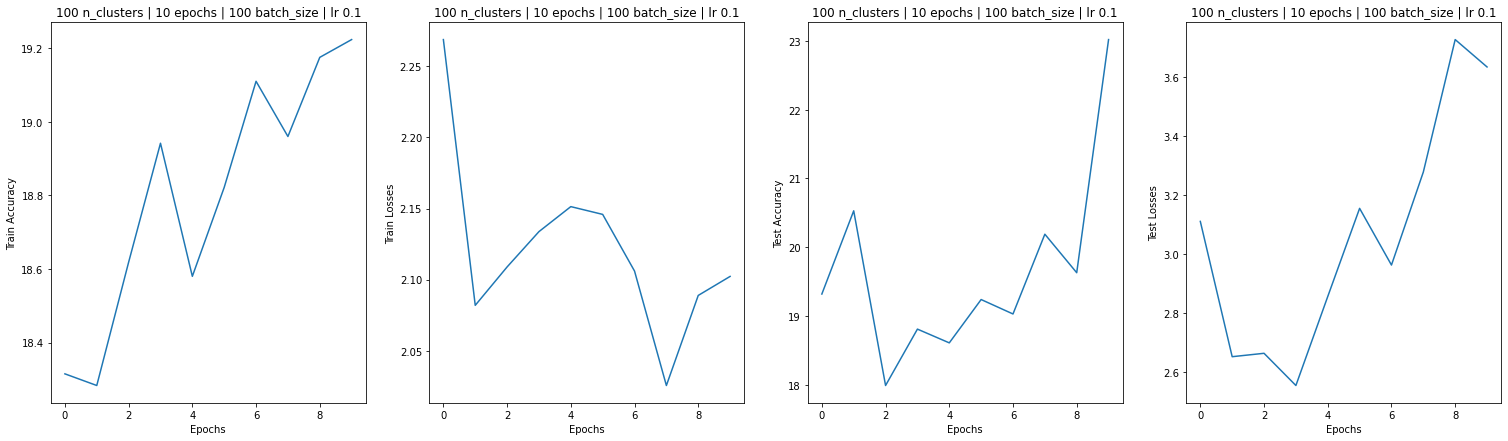

In [726]:
param = "100 n_clusters | 10 epochs | 100 batch_size | lr 0.1"
plt.figure(figsize=(26,7))
plt.subplot(141)
plt.plot(np.array(trn_acc))
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title(param)
plt.subplot(142)
plt.plot(np.array(trn_losses))
plt.xlabel('Epochs')
plt.ylabel('Train Losses')
plt.title(param)
plt.subplot(143)
plt.plot(np.array(tst_acc))
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title(param)
plt.subplot(144)
plt.plot(np.array(tst_losses))
plt.xlabel('Epochs')
plt.ylabel('Test Losses')
plt.title(param)

In [727]:
trn_losses, trn_acc, tst_losses, tst_acc = train(mean_model, 10, 200, 0.1, 5)

PART TRAINING -> epoch :  0 || batch :   60 [12000/60000] || loss: 2.10743833 || accuracy: 19.75833%
PART TRAINING -> epoch :  0 || batch :  120 [24000/60000] || loss: 2.07858586 || accuracy: 19.49583%
PART TRAINING -> epoch :  0 || batch :  180 [36000/60000] || loss: 2.00829959 || accuracy: 19.15000%
PART TRAINING -> epoch :  0 || batch :  240 [48000/60000] || loss: 2.07822013 || accuracy: 19.24167%
PART TRAINING -> epoch :  0 || batch :  300 [60000/60000] || loss: 2.13849592 || accuracy: 19.31667%
TOTAL TRAINING -> epoch :  0 || loss: 2.13849592 || accuracy: 19.31667%
TOTAL TESTING -> epoch :  0 || loss: 4.18078995 || accuracy : 19.87%
PART TRAINING -> epoch :  1 || batch :   60 [12000/60000] || loss: 2.08419394 || accuracy: 19.21667%
PART TRAINING -> epoch :  1 || batch :  120 [24000/60000] || loss: 2.04374218 || accuracy: 19.27500%
PART TRAINING -> epoch :  1 || batch :  180 [36000/60000] || loss: 2.11396861 || accuracy: 19.36111%
PART TRAINING -> epoch :  1 || batch :  240 [48000/

Text(0.5, 1.0, '100 n_clusters | 10 epochs | 200 batch_size | lr 0.1')

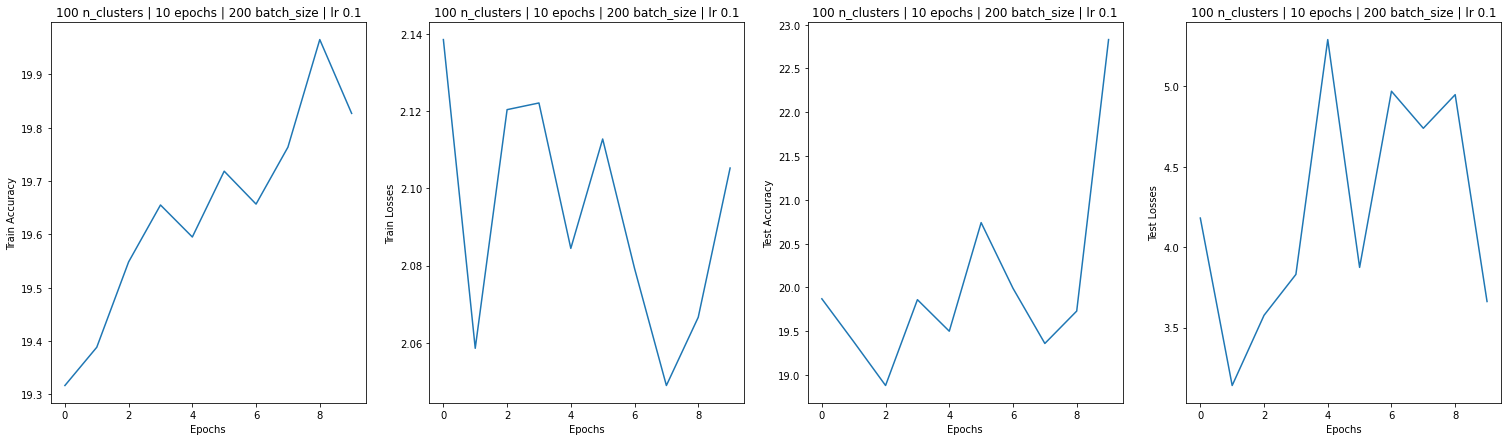

In [732]:
param = "100 n_clusters | 10 epochs | 200 batch_size | lr 0.1"
plt.figure(figsize=(26,7))
plt.subplot(141)
plt.plot(np.array(trn_acc))
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title(param)
plt.subplot(142)
plt.plot(np.array(trn_losses))
plt.xlabel('Epochs')
plt.ylabel('Train Losses')
plt.title(param)
plt.subplot(143)
plt.plot(np.array(tst_acc))
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title(param)
plt.subplot(144)
plt.plot(np.array(tst_losses))
plt.xlabel('Epochs')
plt.ylabel('Test Losses')
plt.title(param)